# ARIMA 

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## Johnson&Johnson Quarterly Earnings per Share 

In [8]:
data = pd.read_csv('data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


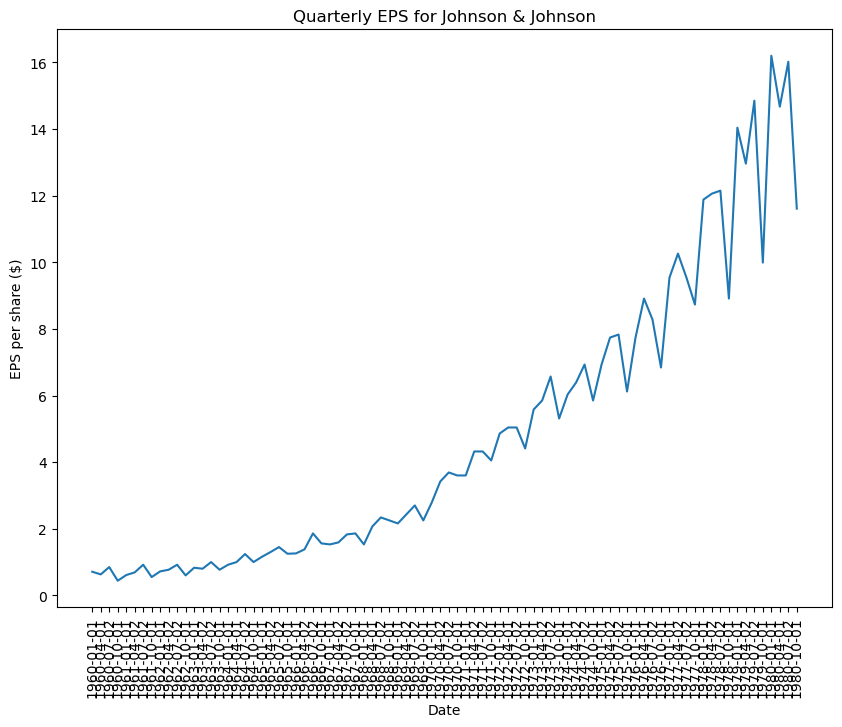

In [9]:
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

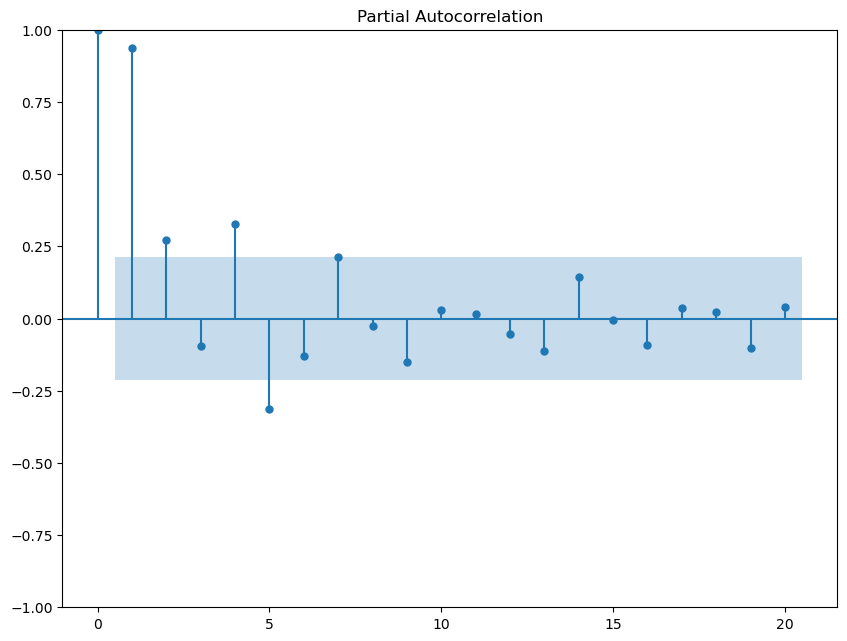

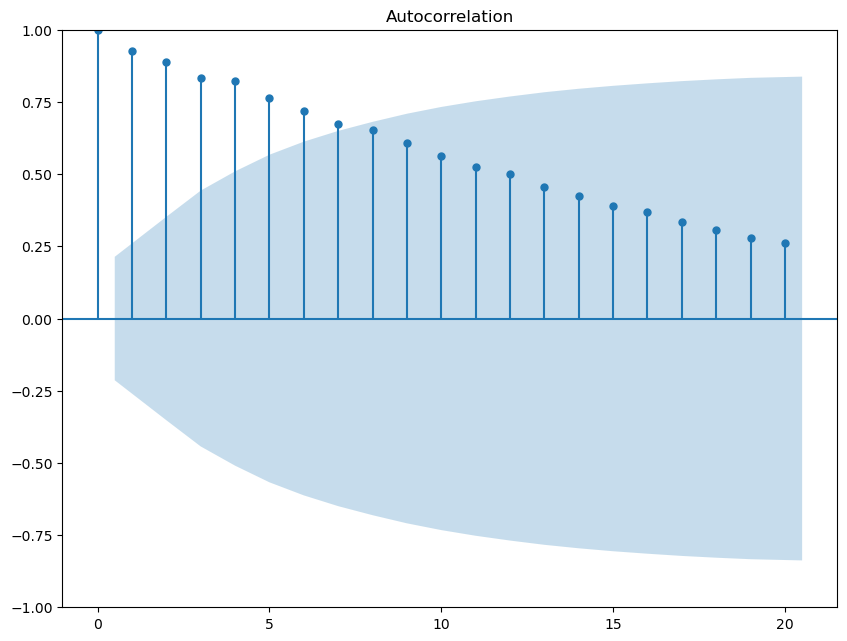

In [10]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [11]:
ad_fuller_result = adfuller(data['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457476
p-value: 1.0


In [12]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


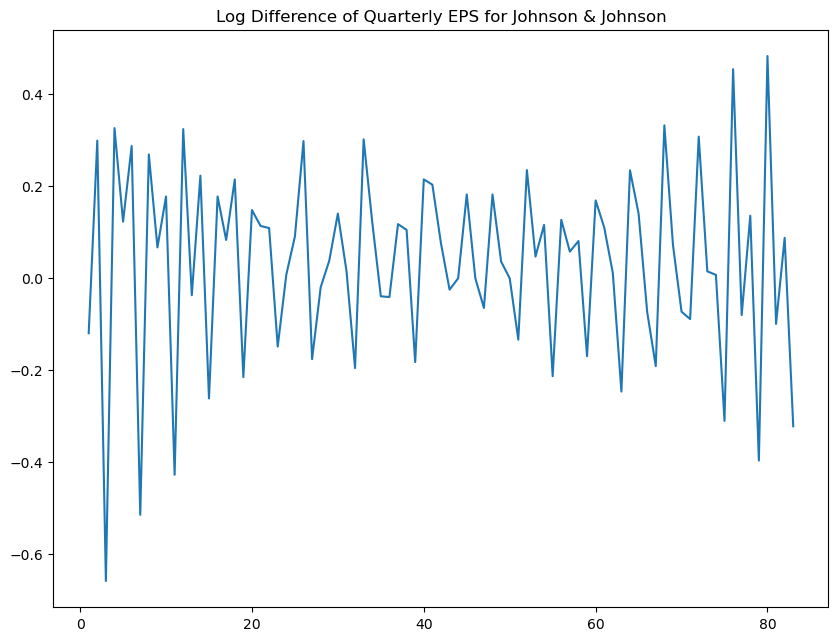

In [13]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [14]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811829
p-value: 0.00041497314044407825


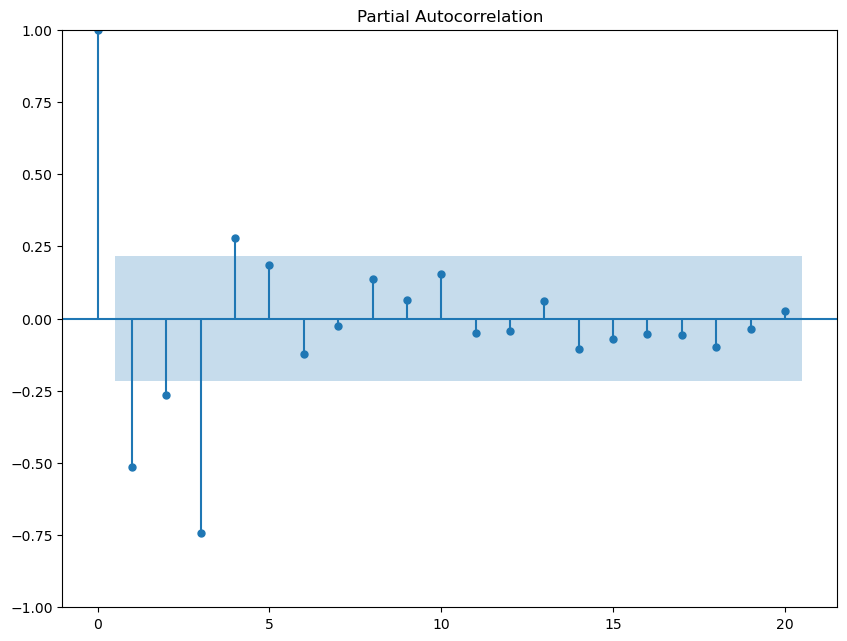

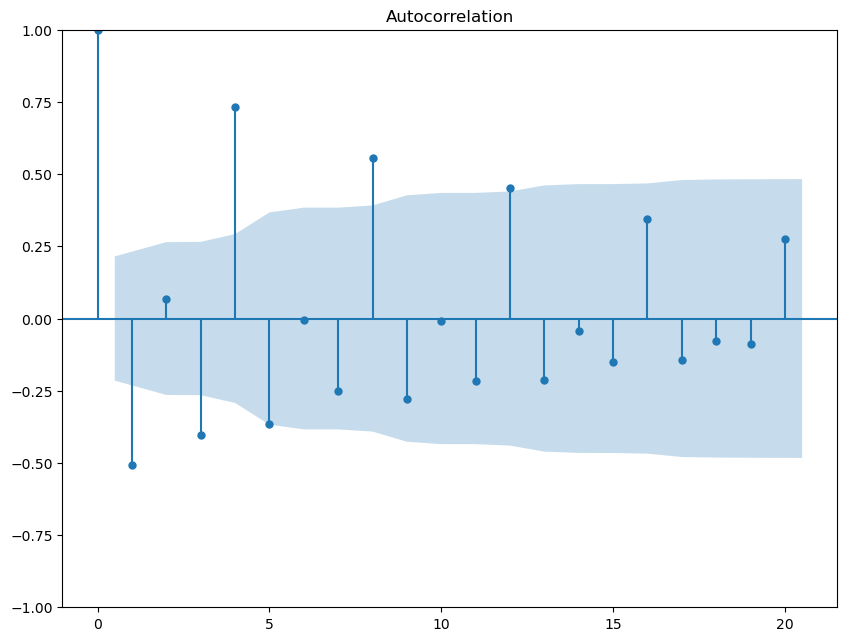

In [15]:
plot_pacf(data['data_tr_1'][1:]);
plot_acf(data['data_tr_1'][1:]);

In [16]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [18]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.670987
1,"(4, 1, 6)",115.859316
2,"(7, 1, 1)",116.092499
3,"(5, 1, 3)",116.536443
4,"(5, 1, 4)",117.242765
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [19]:
best_model = SARIMAX(data['data'], order=(6,1,3), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.835
Date:                Mon, 09 Jan 2023   AIC                            115.671
Time:                        10:16:15   BIC                            139.859
Sample:                             0   HQIC                           125.389
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4530      0.123    -11.811      0.000      -1.694      -1.212
ar.L2         -0.7460      0.144     -5.197      0.000      -1.027      -0.465
ar.L3          0.0388      0.059      0.658      0.5

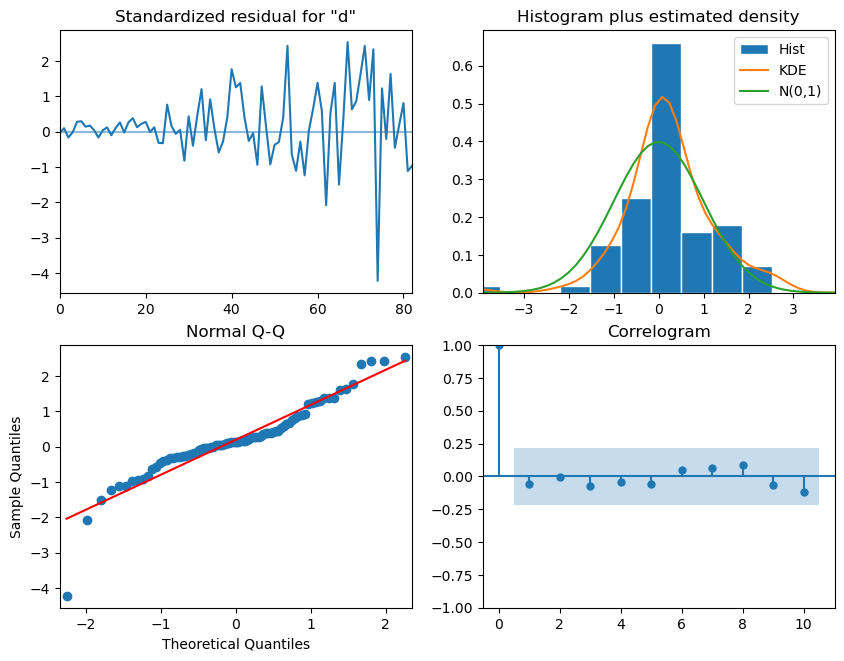

In [20]:
res.plot_diagnostics();

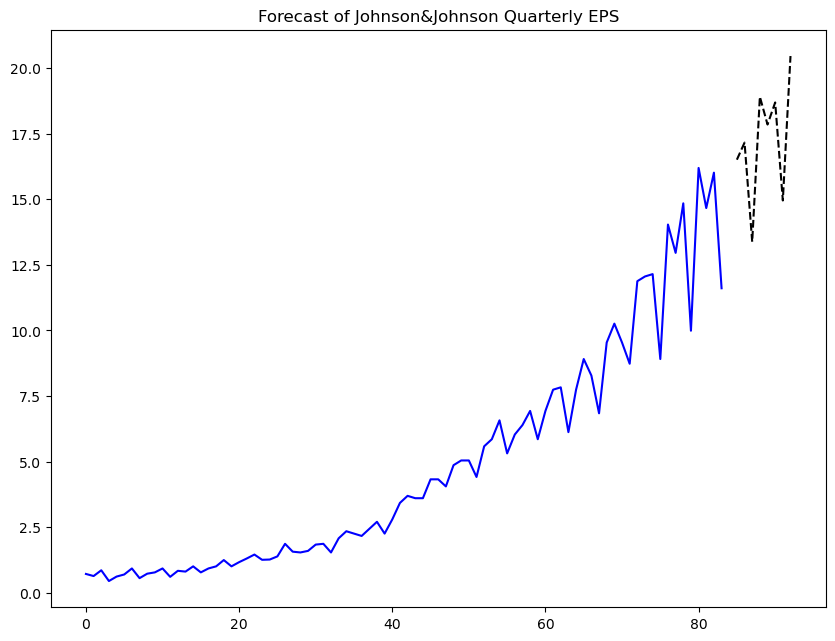

In [21]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Johnson&Johnson Quarterly EPS')
plt.show()

In [22]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.675060
3,1960-10-01,0.44,-0.658462,0.730798
4,1961-01-01,0.61,0.326684,0.639253
5,1961-04-02,0.69,0.123233,0.529138
6,1961-07-02,0.92,0.287682,0.788228
7,1961-10-01,0.55,-0.514455,0.487557
8,1962-01-01,0.72,0.269333,0.646842
9,1962-04-02,0.77,0.067139,0.753579


In [23]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE: {mse}')

MSE: 0.16069401028975427
